In [1]:
#library
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
print(os.listdir("../data"))

['gender_submission.csv', 'prediction_ada.csv', 'prediction_gbm.csv', 'prediction_svm.csv', 'prediction_test.csv', 'prediction_xgb.csv', 'submission_xgb.csv', 'test.csv', 'train.csv']


In [2]:
#import machine leanring lbirary
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

In [3]:
#read in the raw train_df
PATH = "../data"
train_df = pd.read_csv(PATH + "/train.csv")
test_df = pd.read_csv(PATH + "/test.csv")
gender_submission = pd.read_csv(PATH + "/gender_submission.csv")
print(train_df.head())
print(test_df.head())
print(gender_submission.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [4]:
#train_df processing
train_df.isnull().sum() # check the number of null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

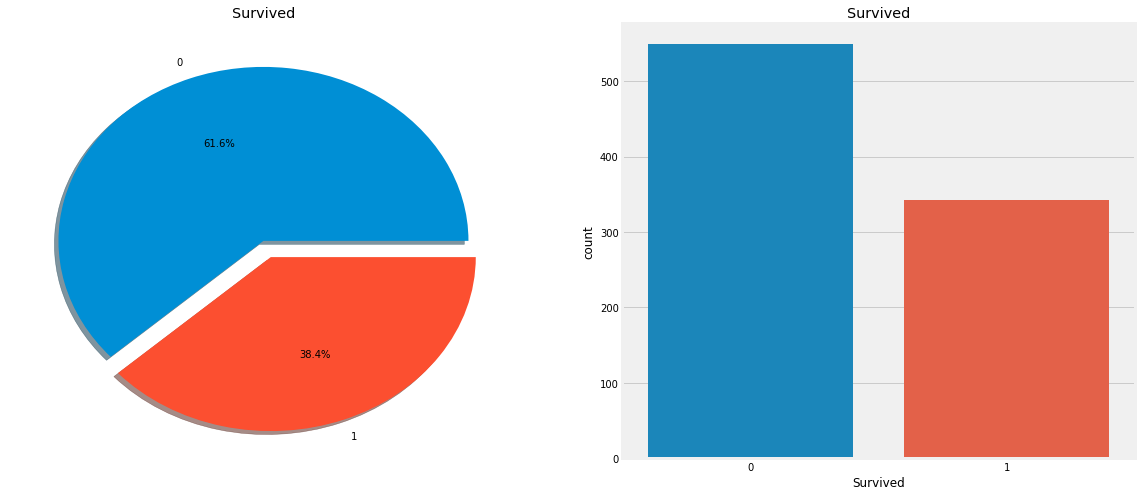

In [5]:
#dependant variable
fig,ax=plt.subplots(1,2,figsize=(18,8))
train_df['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot('Survived',data=train_df,ax=ax[1])
ax[1].set_title('Survived')
plt.show()

In [6]:
#feature analysis-Sex (categorical feature)
train_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

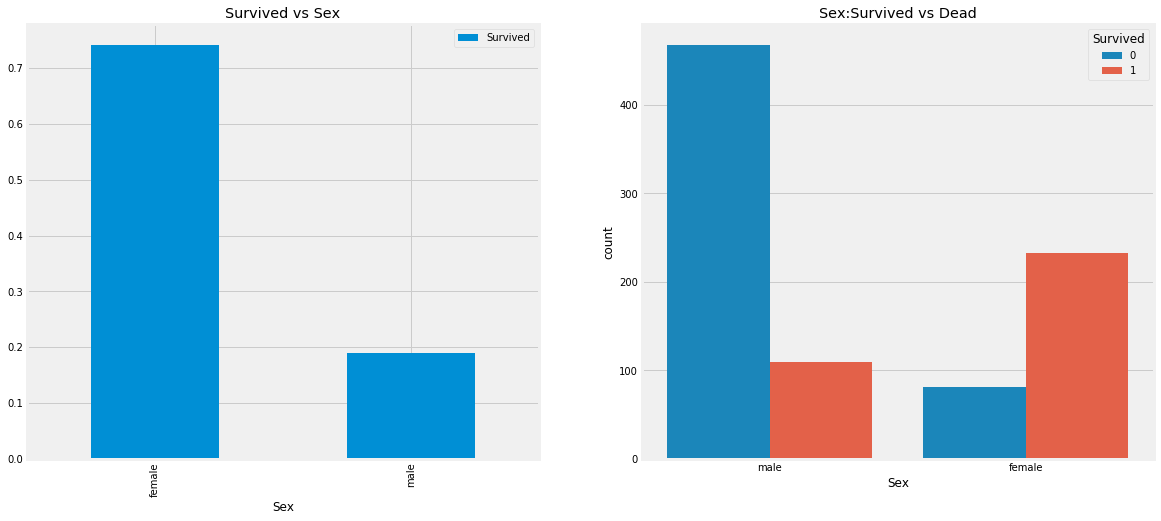

In [7]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
train_df[['Sex','Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex',hue='Survived',data=train_df,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

In [8]:
#feature analysis-Pclass (Ordinal feature)
pd.crosstab(train_df.Pclass,train_df.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


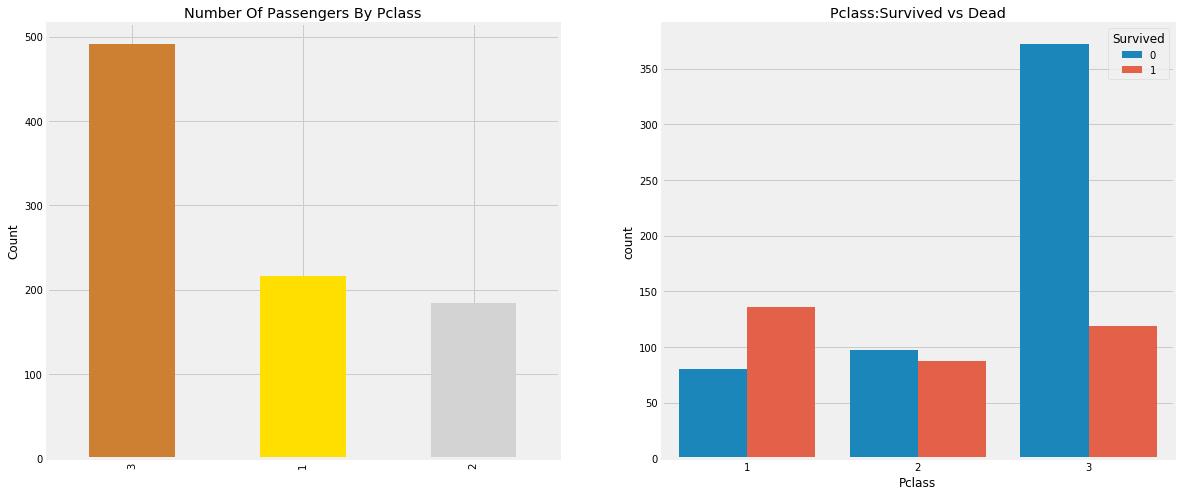

In [9]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
train_df['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax=ax[0])
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=train_df,ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

In [10]:
# feature analysis-Sex and Pclass together
pd.crosstab([train_df.Sex,train_df.Pclass],train_df.Survived,margins=True).style.background_gradient(cmap='summer_r')


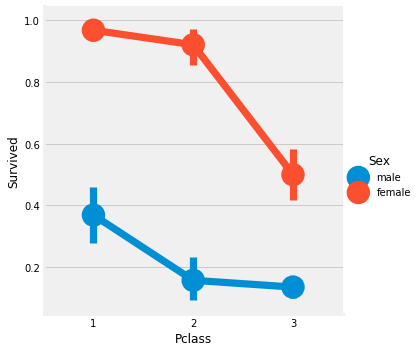

In [11]:
sns.factorplot('Pclass','Survived',hue='Sex',data=train_df)
plt.show()

In [12]:
# feature analysis-Age (Continuous feature)
print('Oldest Passenger was of:',train_df['Age'].max(),'Years')
print('Youngest Passenger was of:',train_df['Age'].min(),'Years')
print('Average Age on the ship:',train_df['Age'].mean(),'Years')


Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.42 Years
Average Age on the ship: 29.69911764705882 Years


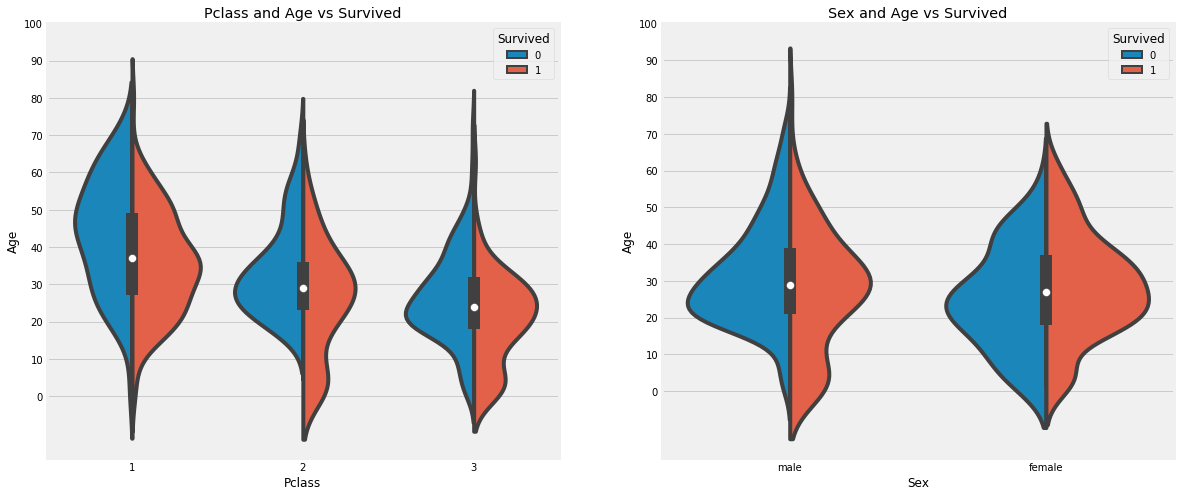

In [13]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age", hue="Survived", data=train_df,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age", hue="Survived", data=train_df,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

In [14]:
#handle the missig value for Age
#find the Salutations and repace the NaN with the mean of age for that group
train_df['Initial']=0
for i in train_df:
    train_df['Initial']=train_df.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

pd.crosstab(train_df.Initial,train_df.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [15]:
#correct the miss-spelling and replace
train_df['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [16]:
#replace the NaN with group mean of age (ceil values of the mean)
train_df.groupby('Initial')['Age'].mean() 
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Mr'),'Age']=33
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Mrs'),'Age']=36
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Master'),'Age']=5
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Miss'),'Age']=22
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Other'),'Age']=46

In [17]:
# check if there is nay NaN value for Age 
train_df.Age.isnull().any()

False

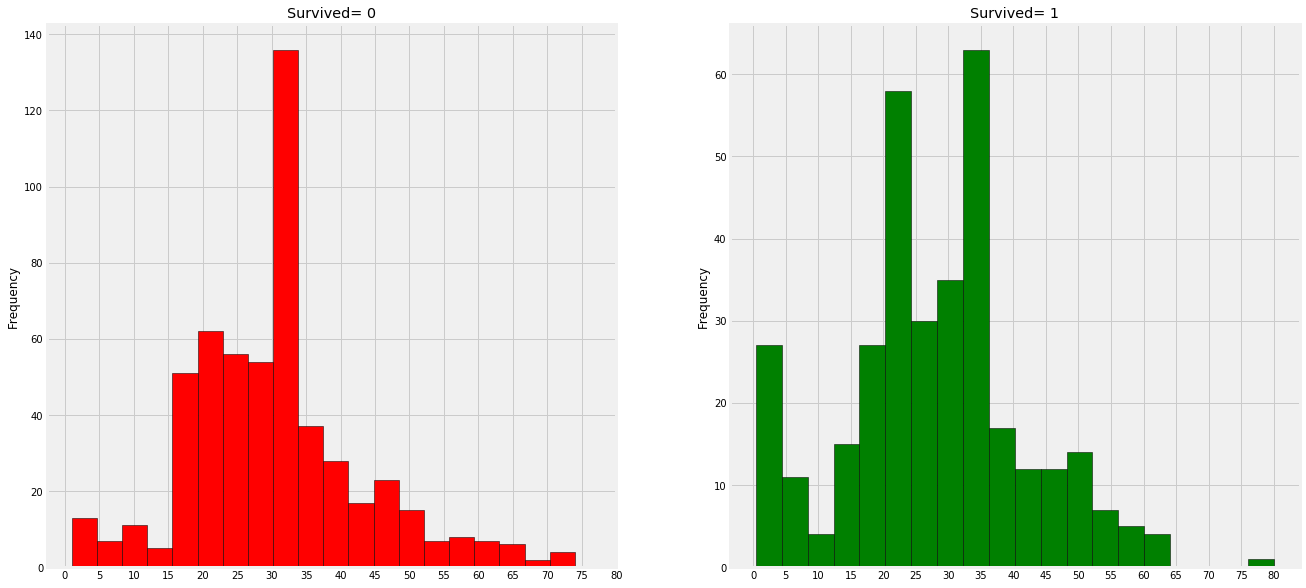

In [18]:
fig,ax=plt.subplots(1,2,figsize=(20,10))
train_df[train_df['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train_df[train_df['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

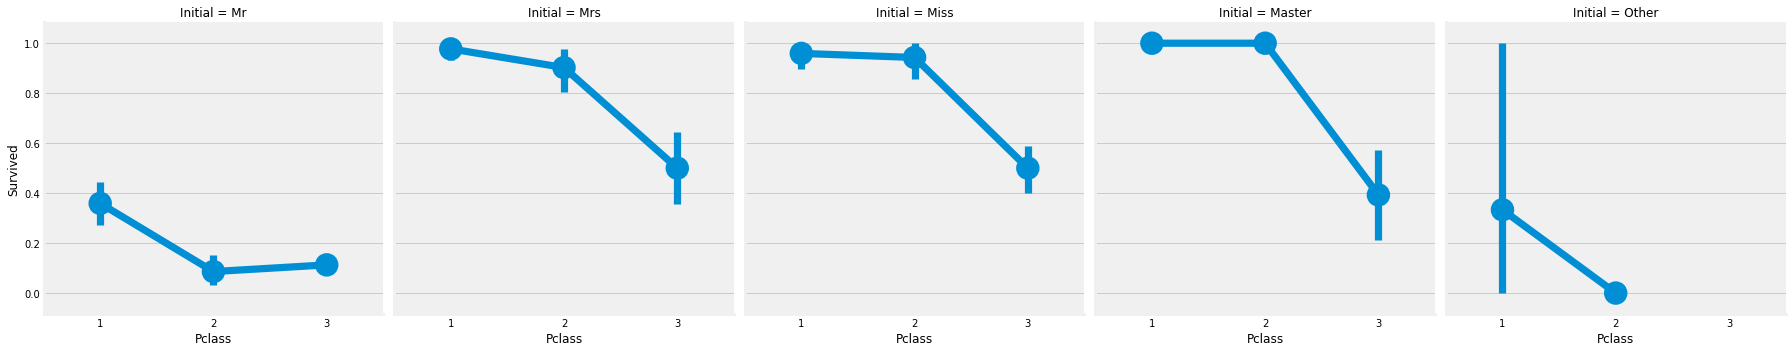

In [19]:
sns.factorplot('Pclass','Survived',col='Initial',data=train_df)
plt.show()

In [20]:
# feature analysis - Embarked (Categorical feature)
pd.crosstab([train_df.Embarked,train_df.Pclass],[train_df.Sex,train_df.Survived],margins=True).style.background_gradient(cmap='summer_r')

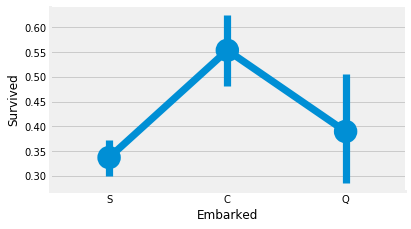

In [21]:
sns.factorplot('Embarked','Survived',data=train_df)
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.show()

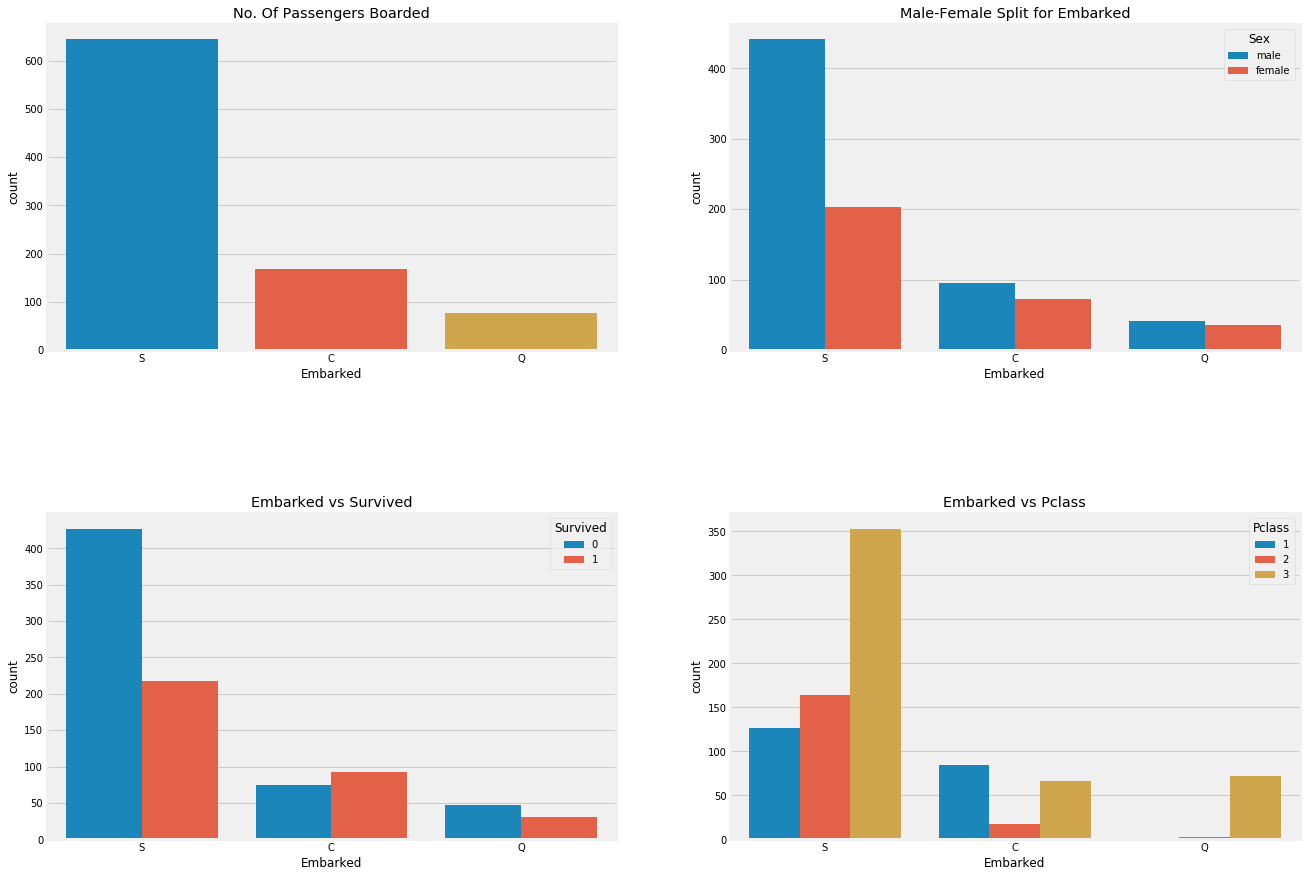

In [22]:
f,ax=plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data=train_df,ax=ax[0,0])
ax[0,0].set_title('No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=train_df,ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')
sns.countplot('Embarked',hue='Survived',data=train_df,ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')
sns.countplot('Embarked',hue='Pclass',data=train_df,ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2,hspace=0.5)
plt.show()

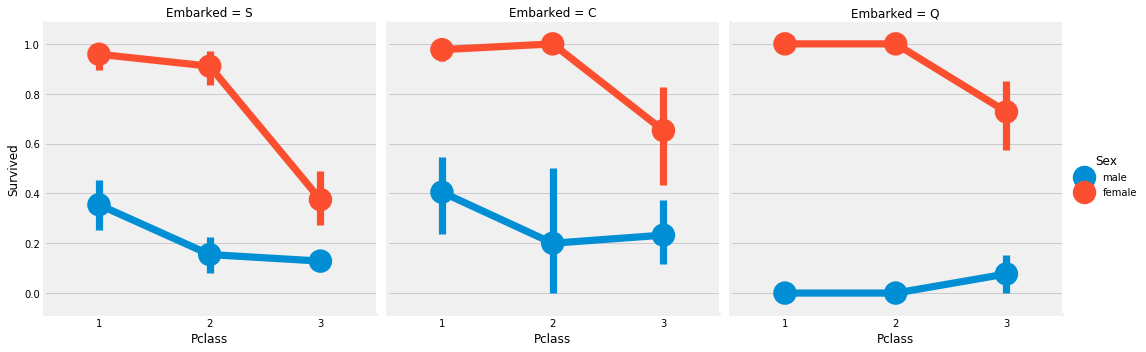

In [23]:
sns.factorplot('Pclass','Survived',hue='Sex',col='Embarked',data=train_df)
plt.show()

In [24]:
#handle the missing value of Embarked
#replace with S since it's the port where most passengers boarded.
train_df['Embarked'].fillna('S',inplace=True)
train_df.Embarked.isnull().any()

False

In [25]:
# feature analysis - SibSip 
pd.crosstab([train_df.SibSp],train_df.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


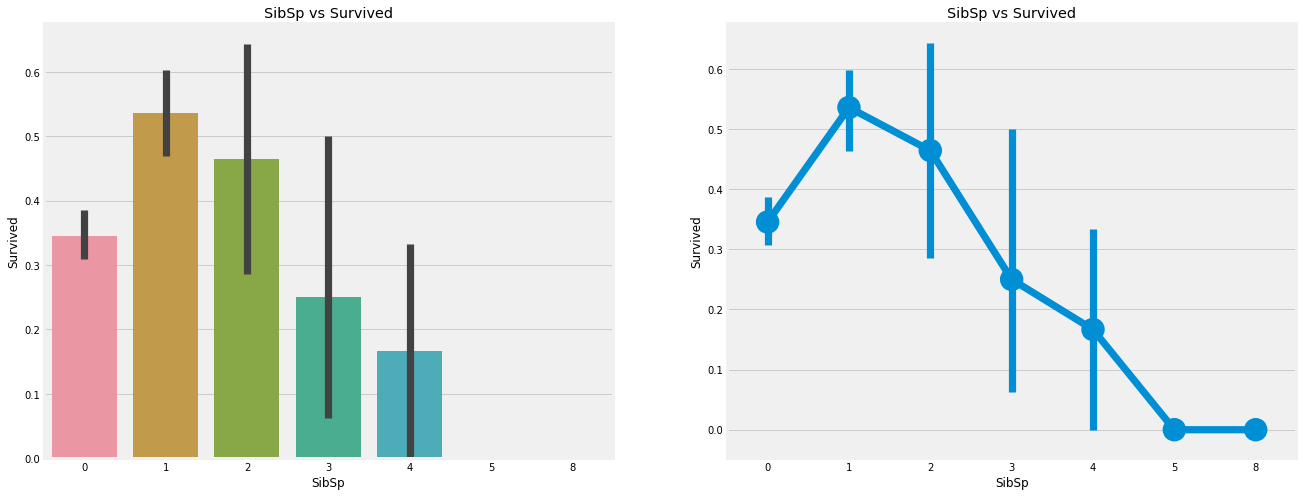

In [26]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=train_df,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=train_df,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()

In [27]:
pd.crosstab(train_df.SibSp,train_df.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


In [28]:
#feature analysis - Parch
pd.crosstab(train_df.Parch,train_df.Pclass).style.background_gradient(cmap='summer_r')


Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


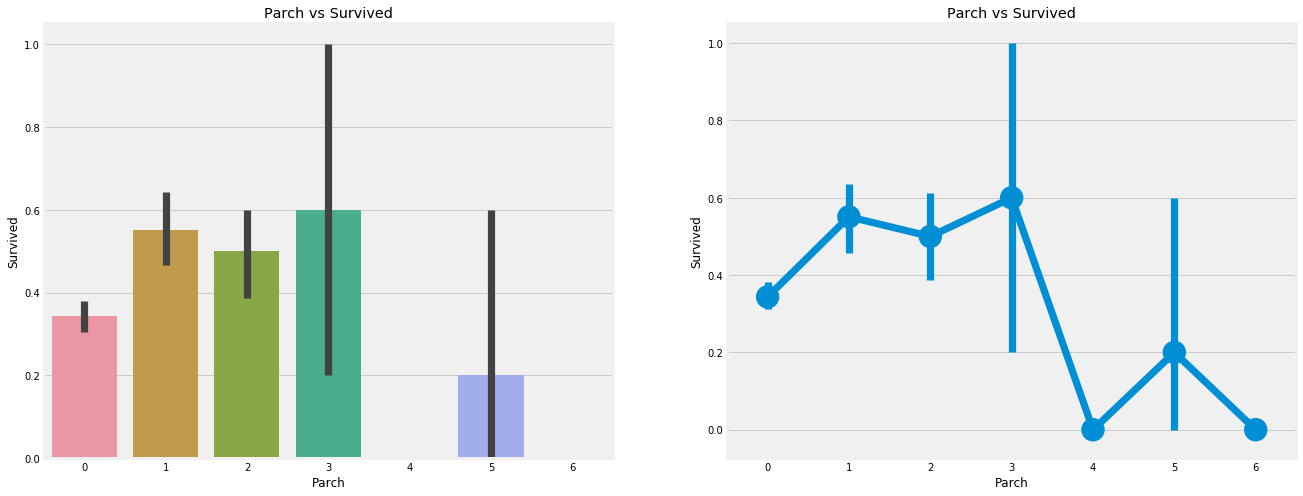

In [29]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('Parch','Survived',data=train_df,ax=ax[0])
ax[0].set_title('Parch vs Survived')
sns.factorplot('Parch','Survived',data=train_df,ax=ax[1])
ax[1].set_title('Parch vs Survived')
plt.close(2)
plt.show()

In [30]:
#feature analysis - Fare (Continuous feature)
print('Highest Fare was:',train_df['Fare'].max())
print('Lowest Fare was:',train_df['Fare'].min())
print('Average Fare was:',train_df['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.2042079685746


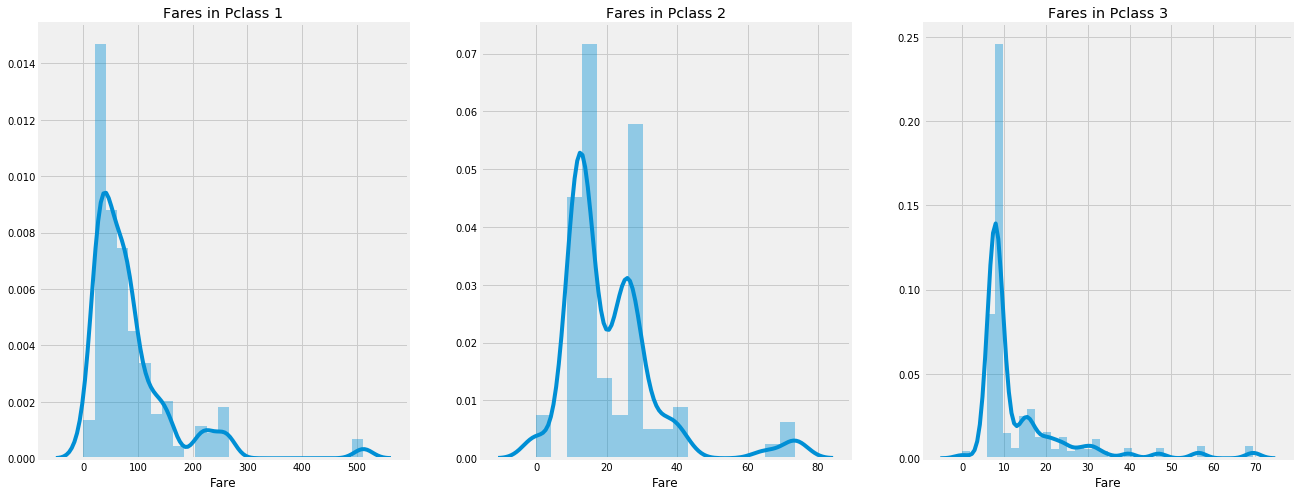

In [31]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(train_df[train_df['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(train_df[train_df['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(train_df[train_df['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

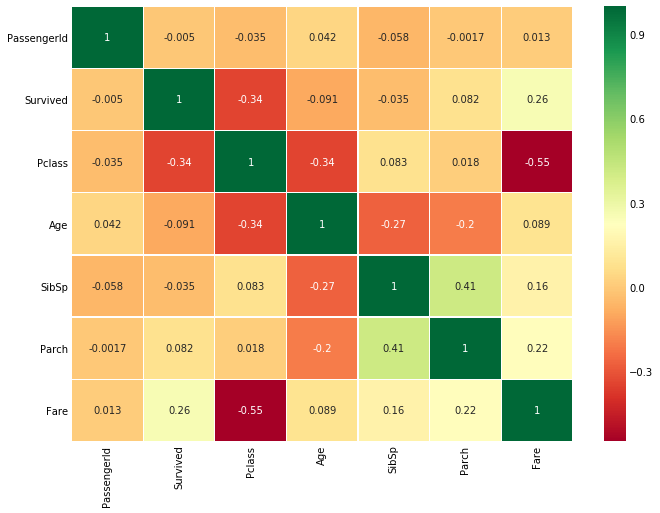

In [32]:
#correlation between features
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [33]:
#feature engineering-Convert Age to categorical variabled 
#(Max is 80,set bin number 5, width 16)
train_df['Age_band']=0
train_df.loc[train_df['Age']<=16,'Age_band']=0
train_df.loc[(train_df['Age']>16)&(train_df['Age']<=32),'Age_band']=1
train_df.loc[(train_df['Age']>32)&(train_df['Age']<=48),'Age_band']=2
train_df.loc[(train_df['Age']>48)&(train_df['Age']<=64),'Age_band']=3
train_df.loc[train_df['Age']>64,'Age_band']=4
train_df.head(2)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [34]:
train_df['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')

,Age_band
1,382
2,325
0,104
3,69
4,11


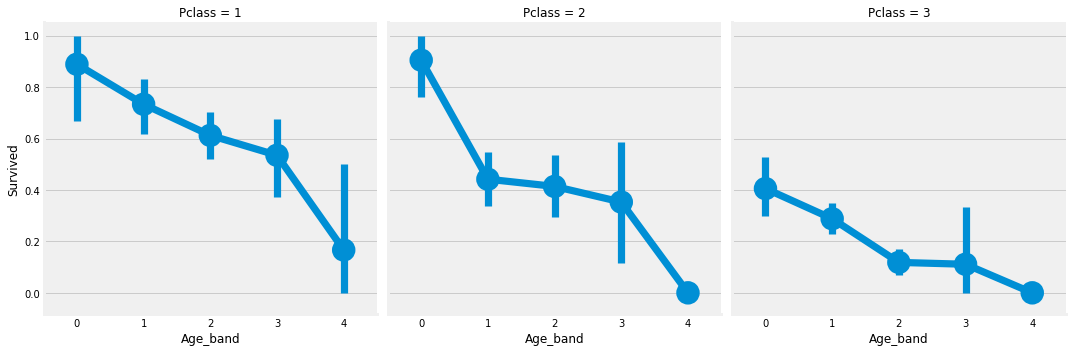

In [35]:
sns.factorplot('Age_band','Survived',data=train_df,col='Pclass')
plt.show()

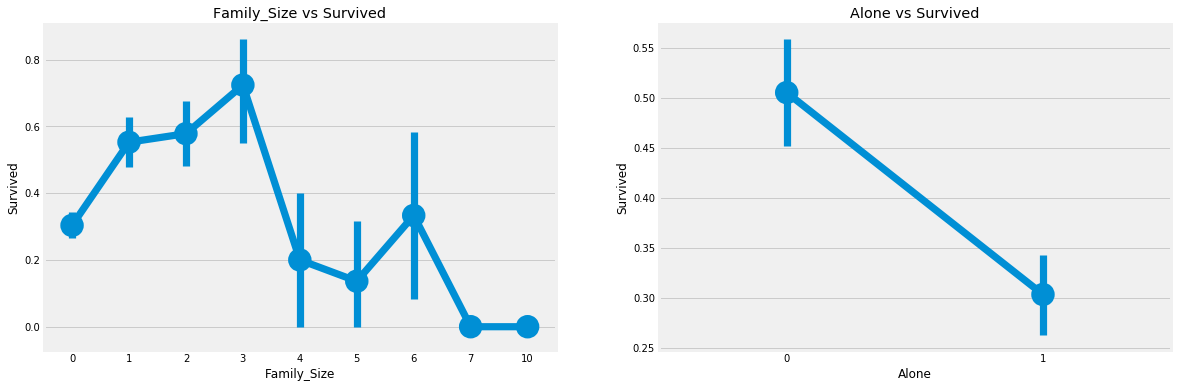

In [36]:
#feature engineering - create new variables Family_Size (sum of Parch and SibSp) 
#and Alone (= 1 if Family_size ==0 otherwise 0)
train_df['Family_Size']=0
train_df['Family_Size']=train_df['Parch']+train_df['SibSp']#family size
train_df['Alone']=0
train_df.loc[train_df.Family_Size==0,'Alone']=1#Alone

f,ax=plt.subplots(1,2,figsize=(18,6))
sns.factorplot('Family_Size','Survived',data=train_df,ax=ax[0])
ax[0].set_title('Family_Size vs Survived')
sns.factorplot('Alone','Survived',data=train_df,ax=ax[1])
ax[1].set_title('Alone vs Survived')
plt.close(2)
plt.close(3)
plt.show()


In [37]:
train_df['Family_Size'].value_counts().to_frame().style.background_gradient(cmap='summer')

,Family_Size
0,537
1,161
2,102
3,29
5,22
4,15
6,12
10,7
7,6


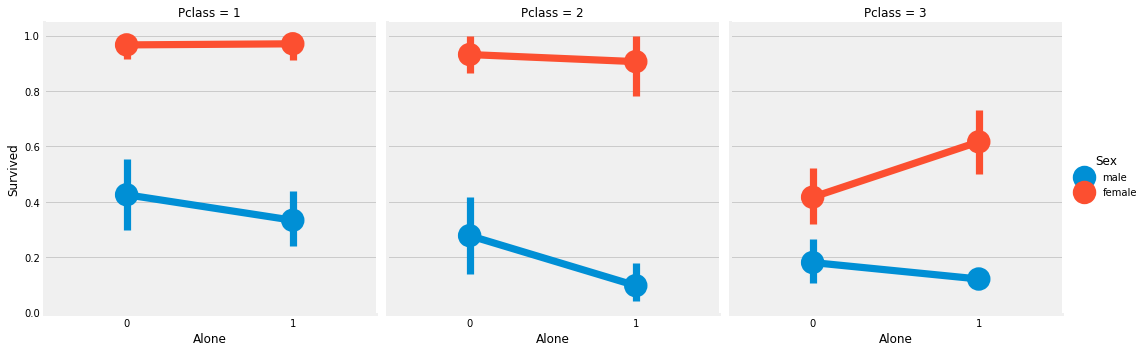

In [38]:
sns.factorplot('Alone','Survived',data=train_df,hue='Sex',col='Pclass')
plt.show()

In [39]:
#feature engineering - convert Fare to categorical feature
#first split the values to be equally space to several bins
#using the bound value to convert to categorical value
train_df['Fare_Range']=pd.qcut(train_df['Fare'],4)
train_df.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


In [40]:
train_df['Fare_cat']=0
train_df.loc[train_df['Fare']<=7.91,'Fare_cat']=0
train_df.loc[(train_df['Fare']>7.91)&(train_df['Fare']<=14.454),'Fare_cat']=1
train_df.loc[(train_df['Fare']>14.454)&(train_df['Fare']<=31),'Fare_cat']=2
train_df.loc[(train_df['Fare']>31)&(train_df['Fare']<=514),'Fare_cat']=3

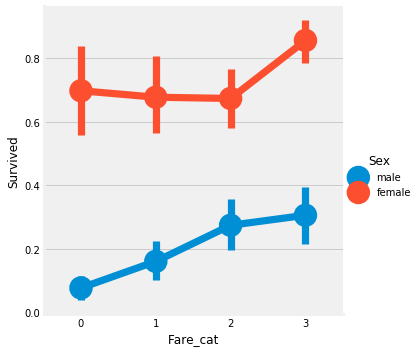

In [41]:
sns.factorplot('Fare_cat','Survived',data=train_df,hue='Sex')
plt.show()

In [42]:
#feature engineering - convert string values to numeric
train_df['Sex'].replace(['male','female'],[0,1],inplace=True)
train_df['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
train_df['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

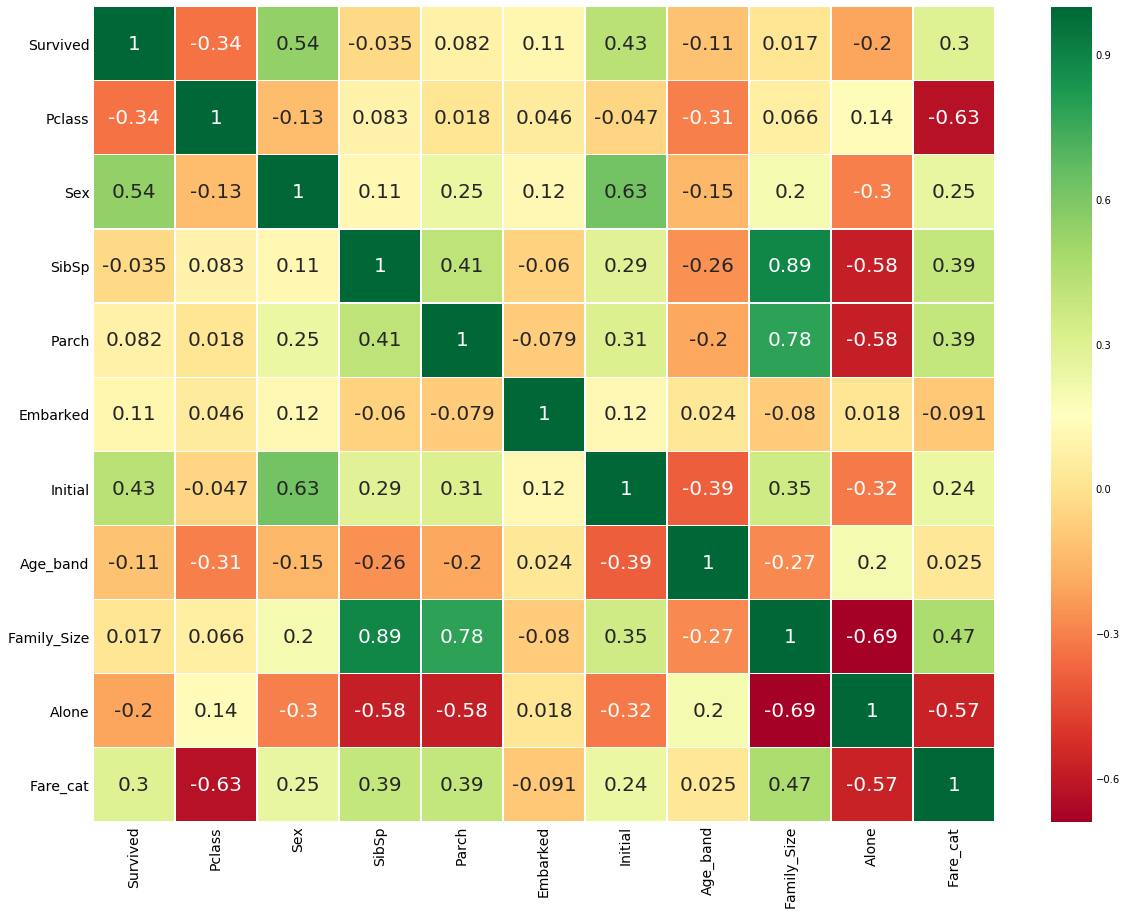

In [43]:
#feature engineering -drop unused features
train_df.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [44]:
#modeling

In [45]:
train,test=train_test_split(train_df,test_size=0.3,random_state=0,stratify=train_df['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=train_df[train_df.columns[1:]]
Y=train_df['Survived']

In [46]:
#Radial Support Vector Machines(rbf-SVM)
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction1,test_Y))

Accuracy for rbf SVM is  0.835820895522388


In [47]:
#Linear Support Vector Machine(linear-SVM)
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(prediction2,test_Y))

Accuracy for linear SVM is 0.8171641791044776


In [48]:
#Logtistic regression
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.8171641791044776


In [49]:
#Decision Tree
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.8134328358208955


In [50]:
#K-Nearest Neighbours (KNN)
model=KNeighborsClassifier() 
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

The accuracy of the KNN is 0.832089552238806


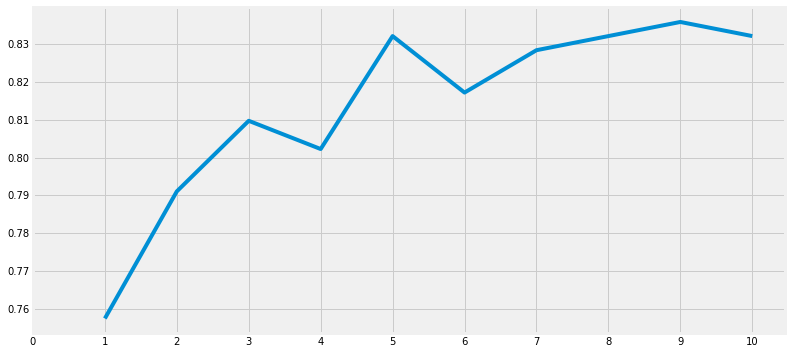

Accuracies for different values of n are: [0.75746269 0.79104478 0.80970149 0.80223881 0.83208955 0.81716418
 0.82835821 0.83208955 0.8358209  0.83208955] with the max value as  0.835820895522388


In [51]:
#Try a bounch of values for the prameter n_neighbours
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

In [52]:
#Gaussian Naive Bayes
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


In [53]:
#Random Forests
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

The accuracy of the Random Forests is 0.8283582089552238


In [54]:
#Cross Validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.793471,0.047797
Radial Svm,0.828290,0.034427
Logistic Regression,0.805843,0.021861
KNN,0.813783,0.041210
Decision Tree,0.806991,0.026207
Naive Bayes,0.801386,0.028999
Random Forest,0.815980,0.035325


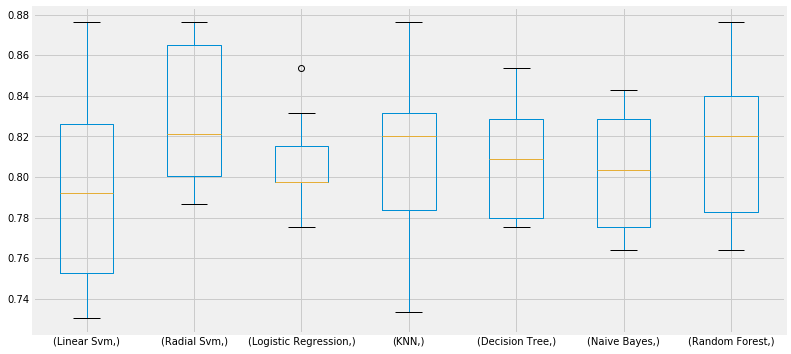

In [55]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()

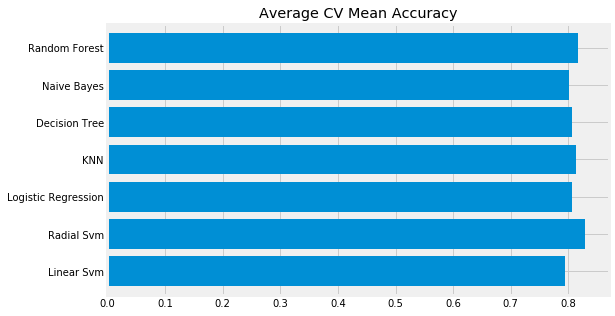

In [56]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

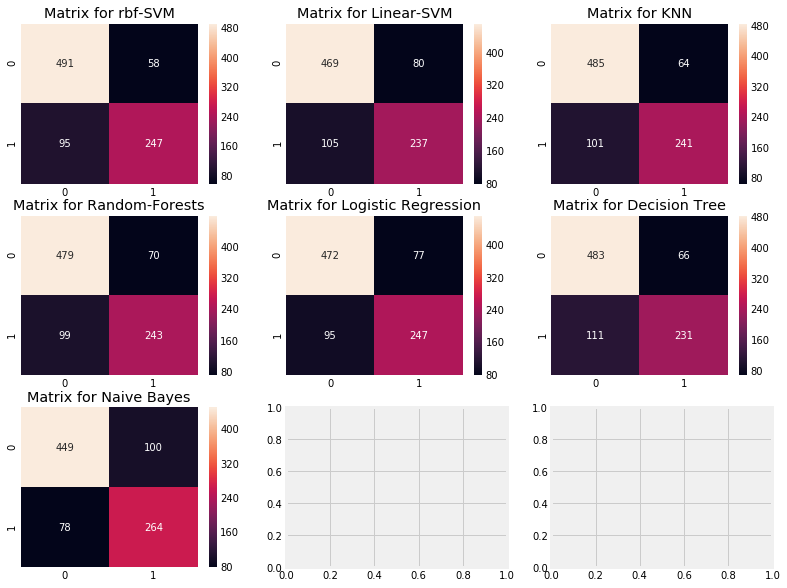

In [57]:
#Confusion Matrix
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

In [58]:
#Hyper-parameters tuning for SVM
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}
gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8282828282828283
SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:   11.4s finished


In [59]:
#hyper-parameter tuning for Randome Forests
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   13.6s finished


0.8170594837261503
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [60]:
#Ensemblling
#Voting Classifier
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], 
                       voting='soft').fit(train_X,train_Y)
print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(test_X,test_Y))
cross=cross_val_score(ensemble_lin_rbf,X,Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.8208955223880597
The cross validated score is 0.8226549199863806


In [61]:
#Bagging_Knn
from sklearn.ensemble import BaggingClassifier
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.835820895522388
The cross validated score for bagged KNN is: 0.8148893428668709


In [62]:
#Bagging-Decision Tree
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y)
prediction=model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_Y))
result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.8246268656716418
The cross validated score for bagged Decision Tree is: 0.8204826353421859


In [63]:
#Boosting
#AdaBoosting
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())


The cross validated score for AdaBoost is: 0.8249526160481218


In [64]:
#Stochastic Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.8182862331176939


In [65]:
#rename the train data set format
train = train_df
target = 'Survived'


In [66]:
###Tuning parameters of GBM models
from sklearn.model_selection import cross_val_score
from sklearn import metrics 
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Survived'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Survived'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Survived'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Survived'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')



Model Report
Accuracy : 0.8563
AUC Score (Train): 0.921074
CV Score : Mean - 0.8827574 | Std - 0.03312584 | Min - 0.8495389 | Max - 0.9342957


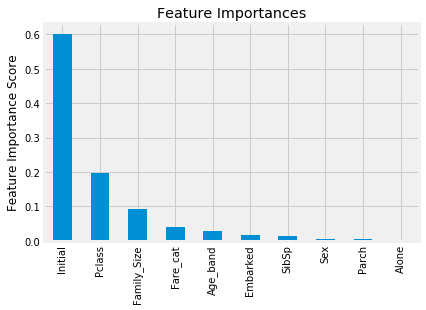

In [67]:
#Choose all predictors except target 
predictors = [x for x in train.columns if x not in [target]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

In [68]:
# 1.tune the optimal number of trees
# if the number of trees is around 20, change the learning rate to 0.05 
# if the number of trees is ~ 100, try a higher learningn rate
# use the following tree specifi parameters temporarily
# min_samples_split = 9 (~0.5-1% of total values)
# min_samples_leaf = 10 (intuition)
# max_depth = 5
# max_features = ‘sqrt’
# subsample = 0.8
predictors = [x for x in train.columns if x not in [target]]
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=9,min_samples_leaf=10,max_depth=5,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)


Model Report
Accuracy : 0.8552
AUC Score (Train): 0.921463
CV Score : Mean - 0.879957 | Std - 0.02745126 | Min - 0.8528986 | Max - 0.9220183


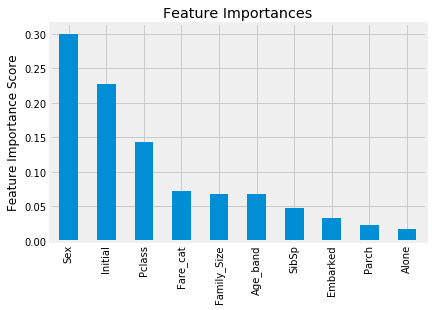

In [69]:
modelfit(gsearch1.best_estimator_, train, predictors)

In [70]:
#check output
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.04339781, 0.05659766, 0.05759397, 0.07879834, 0.11219873,
         0.13379912, 0.13819737]),
  'std_fit_time': array([0.00715256, 0.00412628, 0.00294465, 0.0057061 , 0.00730308,
         0.00563596, 0.01248187]),
  'mean_score_time': array([0.0027977 , 0.0029995 , 0.00240083, 0.00259924, 0.0038013 ,
         0.00380526, 0.00319967]),
  'std_score_time': array([7.46192802e-04, 2.17680210e-06, 4.86718117e-04, 4.88910442e-04,
         4.00762821e-04, 4.02937347e-04, 1.16739119e-03]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'split0_test_score': array([0.86218709, 0.85862978, 0.85019763, 0.84953887, 0.8516469 ,
         0.85

In [71]:
#2.Tuning tree-specific parameters- tune max_depth
# using the optimal tree number 70
# firt tune the high impact parameters, such as max_depth and min_sample_split
# the optimal max_depth is 3
param_test2 = {'max_depth':range(2,10,1), 'min_samples_split':range(4,15,2)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.07339973, 0.06720371, 0.05499992, 0.05400105, 0.05199971,
         0.05219946, 0.06539783, 0.06700053, 0.06580024, 0.0630003 ,
         0.06259956, 0.06539927, 0.08639851, 0.08959789, 0.08459997,
         0.08619804, 0.08799963, 0.08799758, 0.12939992, 0.11979904,
         0.11739902, 0.11420116, 0.11379733, 0.11379867, 0.18359785,
         0.17099991, 0.17019897, 0.1581985 , 0.15699754, 0.14759855,
         0.25699878, 0.2059989 , 0.19559755, 0.20139809, 0.18579912,
         0.17139969, 0.32279997, 0.2849999 , 0.24779868, 0.23739839,
         0.21319838, 0.218606  , 0.38939738, 0.33859978, 0.28299932,
         0.26979885, 0.21939845, 0.20619879]),
  'std_fit_time': array([0.00338051, 0.00607942, 0.00707174, 0.01109536, 0.00497858,
         0.00430805, 0.00500466, 0.00887838, 0.00790967, 0.00374114,
         0.00488111, 0.00523868, 0.00387903, 0.0089791 , 0.00833213,
         0.00630417, 0.00603301, 0.00374279, 0.00588457, 0.0054915 ,
         0.00535119, 0.

In [72]:
#Tuning tree-specific parameters - tune min_samples_split and min_samples_leaf

param_test3 = {'min_samples_split':range(4,15,2), 'min_samples_leaf':range(1,10,1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=3,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.07699676, 0.08299689, 0.07139831, 0.0691988 , 0.07459769,
         0.06799994, 0.08060064, 0.07039962, 0.06599746, 0.06659975,
         0.07579899, 0.07499914, 0.07379823, 0.07539907, 0.0697999 ,
         0.07099814, 0.07679949, 0.07439961, 0.07359986, 0.07599835,
         0.07939911, 0.07679882, 0.08159761, 0.07619772, 0.07139859,
         0.06939917, 0.06859956, 0.07299914, 0.07559967, 0.0747992 ,
         0.06959801, 0.07019839, 0.07299833, 0.06480188, 0.06819634,
         0.07019691, 0.07019825, 0.07439923, 0.07059917, 0.07179894,
         0.06980023, 0.07339826, 0.07119908, 0.06499991, 0.07519927,
         0.06900086, 0.06840019, 0.07520022, 0.07360005, 0.06739993,
         0.07799892, 0.07059917, 0.07479854, 0.06079926]),
  'std_fit_time': array([0.00921299, 0.00809882, 0.00801743, 0.00849341, 0.00300665,
         0.00609739, 0.00326224, 0.00560588, 0.00303472, 0.00595173,
         0.00495607, 0.00363235, 0.00538149, 0.00605336, 0.00652354,
         0.


Model Report
Accuracy : 0.8395
AUC Score (Train): 0.907386
CV Score : Mean - 0.8838895 | Std - 0.02798056 | Min - 0.8485507 | Max - 0.9245818


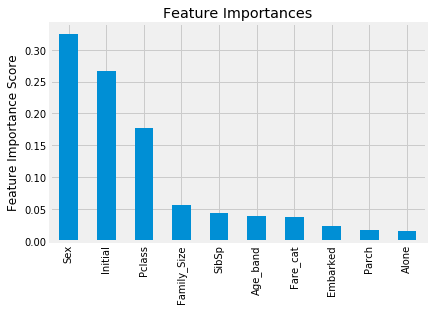

In [73]:
modelfit(gsearch3.best_estimator_, train, predictors)

In [74]:
# tune the max features
# the optimal is 3 which is same as sqrt (sqrt(10)) which is the default.
param_test4 = {'max_features':range(1,6,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=3, min_samples_split=8, min_samples_leaf=3, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([0.06680226, 0.07359924, 0.06899934, 0.07019835, 0.06799717]),
  'std_fit_time': array([0.00837714, 0.00578322, 0.00761281, 0.00511478, 0.00490127]),
  'mean_score_time': array([0.00299888, 0.00320086, 0.00239978, 0.002601  , 0.00240121]),
  'std_score_time': array([1.54806929e-06, 3.99186630e-04, 4.90974208e-04, 7.99704288e-04,
         4.88543245e-04]),
  'param_max_features': masked_array(data=[1, 2, 3, 4, 5],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 1},
   {'max_features': 2},
   {'max_features': 3},
   {'max_features': 4},
   {'max_features': 5}],
  'split0_test_score': array([0.85217391, 0.85968379, 0.85968379, 0.85731225, 0.86310935]),
  'split1_test_score': array([0.84499341, 0.84571805, 0.84855072, 0.84380764, 0.84301713]),
  'split2_test_score': array([0.88983957, 0.89451872, 0.90441176, 0.9       , 0.90093583]),
  'split3_test_score': array([0.88823529

In [75]:
#3.Tuning subsample and making models with lower learning rate
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=3,min_samples_split=8, min_samples_leaf=3, subsample=0.8, random_state=10,max_features=3),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([0.08219938, 0.08140082, 0.07139997, 0.07140007, 0.07339773,
         0.05459695]),
  'std_fit_time': array([0.00343062, 0.0126108 , 0.00480173, 0.00900411, 0.0039305 ,
         0.00337926]),
  'mean_score_time': array([0.00320072, 0.00299916, 0.00260024, 0.00320034, 0.0028008 ,
         0.00200057]),
  'std_score_time': array([3.98673890e-04, 6.33016793e-04, 4.89825442e-04, 4.00044278e-04,
         7.50143777e-04, 8.39558452e-07]),
  'param_subsample': masked_array(data=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.6},
   {'subsample': 0.7},
   {'subsample': 0.75},
   {'subsample': 0.8},
   {'subsample': 0.85},
   {'subsample': 0.9}],
  'split0_test_score': array([0.86903821, 0.86073781, 0.86047431, 0.85968379, 0.85507246,
         0.85823452]),
  'split1_test_score': array([0.84367589, 0.84644269, 0.84617918, 0.84855072, 0.845


Model Report
Accuracy : 0.8395
AUC Score (Train): 0.907386
CV Score : Mean - 0.8838895 | Std - 0.02798056 | Min - 0.8485507 | Max - 0.9245818


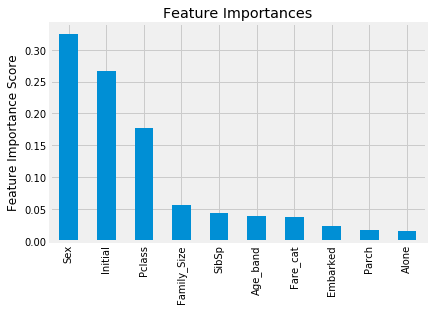

In [76]:
#Try half learning rate-No improvement
predictors = [x for x in train.columns if x not in [target]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=70,max_depth=3,min_samples_split=8, min_samples_leaf=3, subsample=0.8, random_state=10,max_features=3)
modelfit(gbm_tuned_1, train, predictors)

In [77]:
#XGBoost
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


xgboost=xgb.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The cross validated score for XGBoost is: 0.8104710021563954


In [78]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Survived'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print(cvresult) #the number of rows gives the optimum number of trees
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Survived'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Survived'], dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [79]:
#1. Tune the optimum nunber of trees
#Temporarily use the following parameters later on will tune also
# max_depth = 5
# min_child_weight = 1
# gamma = 0
# subsample, colsample_bytree = 0.8
# scale_pos_weight = 1
# We get the number of trees is 29
predictors = [x for x in train.columns if x not in [target]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.869698       0.005379       0.852689      0.031122
1         0.883926       0.005335       0.864716      0.028526
2         0.885594       0.004455       0.868235      0.022857
3         0.886134       0.004253       0.869816      0.023410
4         0.888800       0.002121       0.868927      0.023052
5         0.892340       0.004930       0.873111      0.021705
6         0.895010       0.004128       0.874753      0.022980
7         0.898634       0.003243       0.879836      0.017880
8         0.900406       0.002815       0.881017      0.017883
9         0.901237       0.002651       0.880117      0.018478
10        0.902768       0.003104       0.879462      0.017155
11        0.904662       0.003240       0.880698      0.016824
12        0.906341       0.002718       0.881165      0.015376
13        0.906612       0.002880       0.881169      0.016569
14        0.907439       0.003221       0.881757      0

In [80]:
#tune max_depth and min_child_weight
param_test1 = {
 'max_depth':range(1,6,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=29, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([0.03519883, 0.02639737, 0.02480021, 0.01999936, 0.02139831,
         0.02399964, 0.02320046, 0.02400002, 0.02359877, 0.02619991,
         0.03140035, 0.03019924, 0.03119888, 0.03119874, 0.03399897,
         0.04039936, 0.03939958, 0.03919868, 0.03860002, 0.03739948,
         0.04640021, 0.04479866, 0.04359941, 0.04139848, 0.03240013]),
  'std_fit_time': array([0.00248207, 0.00320214, 0.00271608, 0.00189733, 0.0004896 ,
         0.00063226, 0.00193864, 0.00154964, 0.0004887 , 0.0016001 ,
         0.00241707, 0.0014691 , 0.00146872, 0.00193809, 0.00227964,
         0.00355531, 0.00241583, 0.00193966, 0.00120049, 0.00101901,
         0.00149643, 0.00183227, 0.00049129, 0.00079968, 0.00671118]),
  'mean_score_time': array([0.00380259, 0.00359955, 0.00340014, 0.00339894, 0.0033998 ,
         0.00320044, 0.00340104, 0.00320096, 0.0034009 , 0.00340018,
         0.00360107, 0.00360026, 0.00360126, 0.00380087, 0.00340071,
         0.00420098, 0.00380082, 0.00380163, 0.

In [81]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=29, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([0.056599  , 0.05019593, 0.04439802, 0.05059891, 0.04799905,
         0.04219956, 0.04819841, 0.04839826, 0.0381988 ]),
  'std_fit_time': array([0.0037757 , 0.00426296, 0.00771038, 0.00833374, 0.0070718 ,
         0.00039962, 0.00146968, 0.00241679, 0.00670421]),
  'mean_score_time': array([0.00400047, 0.00400028, 0.00360155, 0.00360026, 0.00440049,
         0.00360146, 0.00400071, 0.00380106, 0.00420079]),
  'std_score_time': array([1.91567511e-06, 6.32787498e-04, 4.90469147e-04, 4.89416251e-04,
         4.89882618e-04, 4.89610060e-04, 6.34068918e-04, 4.00519836e-04,
         3.99900460e-04]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, 

In [82]:
#confirm the optimum min_child_weight is 4
param_test2b = {
 'min_child_weight':[4,6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=140, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [4, 6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [83]:
modelfit(gsearch2b.best_estimator_, train, predictors)
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.860783       0.006717       0.849856      0.025319
1         0.872630       0.005356       0.859846      0.024295
2         0.875220       0.006109       0.866449      0.022104
3         0.876360       0.004977       0.867506      0.023558
4         0.878499       0.005321       0.866685      0.023656
5         0.881269       0.006953       0.869874      0.023074
6         0.884184       0.005057       0.871653      0.025158
7         0.887971       0.002468       0.874980      0.023586
8         0.889559       0.001667       0.875895      0.022849
9         0.891163       0.003258       0.878364      0.019828
10        0.892136       0.003331       0.878994      0.017389
11        0.892786       0.003296       0.879514      0.017061
12        0.893230       0.003020       0.879417      0.019121
13        0.894432       0.002899       0.880065      0.017814
14        0.894559       0.003058       0.880053      0

({'mean_fit_time': array([0.20579681, 0.18299875, 0.18679743, 0.16259975, 0.1487999 ]),
  'std_fit_time': array([0.0117873 , 0.01508606, 0.00318736, 0.00496502, 0.01643458]),
  'mean_score_time': array([0.00480199, 0.00480046, 0.00440068, 0.00420084, 0.00419912]),
  'std_score_time': array([0.00097996, 0.00074881, 0.00048885, 0.00040131, 0.00039871]),
  'param_min_child_weight': masked_array(data=[4, 6, 8, 10, 12],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 4},
   {'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'split0_test_score': array([0.85362319, 0.84953887, 0.84802372, 0.84888011, 0.84505929]),
  'split1_test_score': array([0.85527009, 0.85144928, 0.86014493, 0.85757576, 0.85296443]),
  'split2_test_score': array([0.9138369 , 0.9084893 , 0.90755348, 0.89879679, 0.89512032]),
  'split3_test_score': array([0.86878342,

In [84]:
#Tune gamma
# This show the initial gamma is optimal
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=29, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([0.04899812, 0.04539719, 0.04020047, 0.04019799, 0.0377996 ]),
  'std_fit_time': array([0.00209715, 0.00449636, 0.00132626, 0.00097964, 0.00278523]),
  'mean_score_time': array([0.0036005 , 0.00319886, 0.00399971, 0.00340114, 0.00380087]),
  'std_score_time': array([4.89416577e-04, 4.00189573e-04, 1.91923254e-06, 4.89805137e-04,
         3.98636064e-04]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.85559947, 0.85586298, 0.856917  , 0.85685112, 0.85737813]),
  'split1_test_score': array([0.85711462, 0.85698287, 0.8557971 , 0.85698287, 0.85533597]),
  'split2_test_score': array([0.90681818, 0.90427807, 0.90387701, 0.9040107 , 0.90441176]),
  'split3_test_score': array([0.87372995, 0.8736631 , 0.877807

In [85]:
#model till now
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=29,
 max_depth=5,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.860783       0.006717       0.849856      0.025319
1         0.872630       0.005356       0.859846      0.024295
2         0.875220       0.006109       0.866449      0.022104
3         0.876360       0.004977       0.867506      0.023558
4         0.878499       0.005321       0.866685      0.023656
5         0.881269       0.006953       0.869874      0.023074
6         0.884184       0.005057       0.871653      0.025158
7         0.887971       0.002468       0.874980      0.023586
8         0.889559       0.001667       0.875895      0.022849
9         0.891163       0.003258       0.878364      0.019828
10        0.892136       0.003331       0.878994      0.017389
11        0.892786       0.003296       0.879514      0.017061
12        0.893230       0.003020       0.879417      0.019121
13        0.894432       0.002899       0.880065      0.017814
14        0.894559       0.003058       0.880053      0

In [86]:
#4. Tune subsample and closample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=29, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([0.0505969 , 0.04939885, 0.04060144, 0.0411993 , 0.04139938,
         0.04119902, 0.04100008, 0.04179907, 0.04299707, 0.04220123,
         0.04179983, 0.04619918, 0.04479856, 0.04500027, 0.04039922,
         0.04019904]),
  'std_fit_time': array([0.00402962, 0.00677084, 0.00135647, 0.00203875, 0.00265379,
         0.00193929, 0.00154751, 0.00074807, 0.00227837, 0.00116472,
         0.00132634, 0.00146957, 0.00116527, 0.00167251, 0.00512254,
         0.00386739]),
  'mean_score_time': array([0.00360188, 0.0036006 , 0.00379901, 0.00380087, 0.00380077,
         0.00400095, 0.00420094, 0.00399976, 0.00320163, 0.00360107,
         0.00360122, 0.00380068, 0.00340109, 0.00400095, 0.00420113,
         0.00420046]),
  'std_score_time': array([4.89181117e-04, 4.90381058e-04, 3.98899617e-04, 3.99710835e-04,
         4.00495770e-04, 1.20064529e-06, 4.01262024e-04, 1.88576888e-06,
         3.99283079e-04, 4.89687548e-04, 4.89225225e-04, 3.99614444e-04,
         4.88968581e-

In [87]:
#another round with 0.05 step
#the optimal should be 0.8 and 0.8
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=29, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([0.06219673, 0.05119834, 0.04120021, 0.0423996 , 0.04299898,
         0.04299846, 0.0431993 , 0.04399967, 0.03459978]),
  'std_fit_time': array([0.00305864, 0.00860991, 0.00193826, 0.00149606, 0.00260846,
         0.00109611, 0.00146991, 0.00126527, 0.00422248]),
  'mean_score_time': array([0.00440087, 0.00379982, 0.00380087, 0.00340109, 0.00379992,
         0.00380092, 0.00340075, 0.00360055, 0.00400133]),
  'std_score_time': array([1.85358678e-03, 4.00736785e-04, 3.99708958e-04, 4.89260727e-04,
         4.00545994e-04, 3.99973282e-04, 4.89434272e-04, 4.90040386e-04,
         3.68863670e-06]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[F

In [88]:
# tune Regularization parameters
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=29, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([0.06079893, 0.05659933, 0.04179816, 0.03879929, 0.02279906]),
  'std_fit_time': array([0.00743975, 0.00906933, 0.00213598, 0.00203939, 0.00040069]),
  'mean_score_time': array([0.00400138, 0.00400066, 0.00360088, 0.00360084, 0.0034008 ]),
  'std_score_time': array([0.00063498, 0.00063204, 0.00049002, 0.00049027, 0.0004893 ]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.85559947, 0.85573123, 0.85922266, 0.85322793, 0.81758893]),
  'split1_test_score': array([0.85711462, 0.85711462, 0.85790514, 0.85480896, 0.81027668]),
  'split2_test_score': array([0.90681818, 0.90681818, 0.90534759, 0.9059492 , 0.78415775]),
  'split3_test_score': array([0.87372995, 0.87413102, 0.87399733,

In [89]:
param_test7 = {
 'reg_alpha':[0,0.01, 0.02, 0.05,0.08, 0.1,0.12,0.15,0.2,0.25,0.5]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=29, max_depth=5,
 min_child_weight=4, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([0.05939736, 0.05439906, 0.04500017, 0.04680071, 0.04740033,
         0.04479852, 0.0448    , 0.04519968, 0.04619956, 0.04639988,
         0.04459848]),
  'std_fit_time': array([0.00462918, 0.00392943, 0.00678293, 0.00643148, 0.00427169,
         0.00193729, 0.00172077, 0.00231567, 0.0013259 , 0.00349723,
         0.00249691]),
  'mean_score_time': array([0.00420194, 0.00380058, 0.00400019, 0.00360084, 0.00399914,
         0.00399909, 0.00400009, 0.00400219, 0.00399981, 0.00400095,
         0.00400095]),
  'std_score_time': array([3.98259676e-04, 4.00411703e-04, 5.43678010e-07, 4.90274403e-04,
         1.54218308e-06, 2.00385107e-06, 6.32636026e-04, 6.32486423e-04,
         6.31506138e-04, 6.31580697e-04, 6.30376115e-04]),
  'param_reg_alpha': masked_array(data=[0, 0.01, 0.02, 0.05, 0.08, 0.1, 0.12, 0.15, 0.2, 0.25,
                     0.5],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False],


In [90]:
#model till now-dont use reg-alpha
xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=29,
 max_depth=5,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.860783       0.006717       0.849856      0.025319
1         0.872630       0.005356       0.859846      0.024295
2         0.875220       0.006109       0.866449      0.022104
3         0.876360       0.004977       0.867506      0.023558
4         0.878499       0.005321       0.866685      0.023656
5         0.881269       0.006953       0.869874      0.023074
6         0.884184       0.005057       0.871653      0.025158
7         0.887971       0.002468       0.874980      0.023586
8         0.889559       0.001667       0.875895      0.022849
9         0.891163       0.003258       0.878364      0.019828
10        0.892136       0.003331       0.878994      0.017389
11        0.892786       0.003296       0.879514      0.017061
12        0.893230       0.003020       0.879417      0.019121
13        0.894432       0.002899       0.880065      0.017814
14        0.894559       0.003058       0.880053      0

In [91]:
#lower learning rate
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=290,
 max_depth=5,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.860783       0.006717       0.849856      0.025319
1          0.872880       0.005326       0.860019      0.024997
2          0.874041       0.005253       0.865694      0.025010
3          0.875625       0.004786       0.868276      0.024298
4          0.876738       0.004990       0.868158      0.024004
..              ...            ...            ...           ...
191        0.898575       0.003766       0.880410      0.019360
192        0.898678       0.003719       0.880571      0.019287
193        0.898777       0.003648       0.880593      0.019249
194        0.898966       0.003522       0.880547      0.019220
195        0.898973       0.003642       0.880856      0.019457

[196 rows x 4 columns]

Model Report
Accuracy : 0.844
AUC Score (Train): 0.899512


In [92]:
#model till now
xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=29,
 max_depth=5,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.860783       0.006717       0.849856      0.025319
1         0.872630       0.005356       0.859846      0.024295
2         0.875220       0.006109       0.866449      0.022104
3         0.876360       0.004977       0.867506      0.023558
4         0.878499       0.005321       0.866685      0.023656
5         0.881269       0.006953       0.869874      0.023074
6         0.884184       0.005057       0.871653      0.025158
7         0.887971       0.002468       0.874980      0.023586
8         0.889559       0.001667       0.875895      0.022849
9         0.891163       0.003258       0.878364      0.019828
10        0.892136       0.003331       0.878994      0.017389
11        0.892786       0.003296       0.879514      0.017061
12        0.893230       0.003020       0.879417      0.019121
13        0.894432       0.002899       0.880065      0.017814
14        0.894559       0.003058       0.880053      0

In [93]:
#Hyper-parameter tuning for AdaBoost
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  4.1min finished


0.8316498316498316
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.05, n_estimators=200, random_state=None)


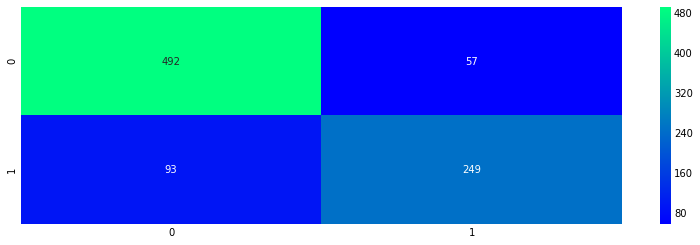

In [94]:
#confusion matrix for AdaBoost
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result=cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

In [95]:
#confusion matrix for XGBoost 


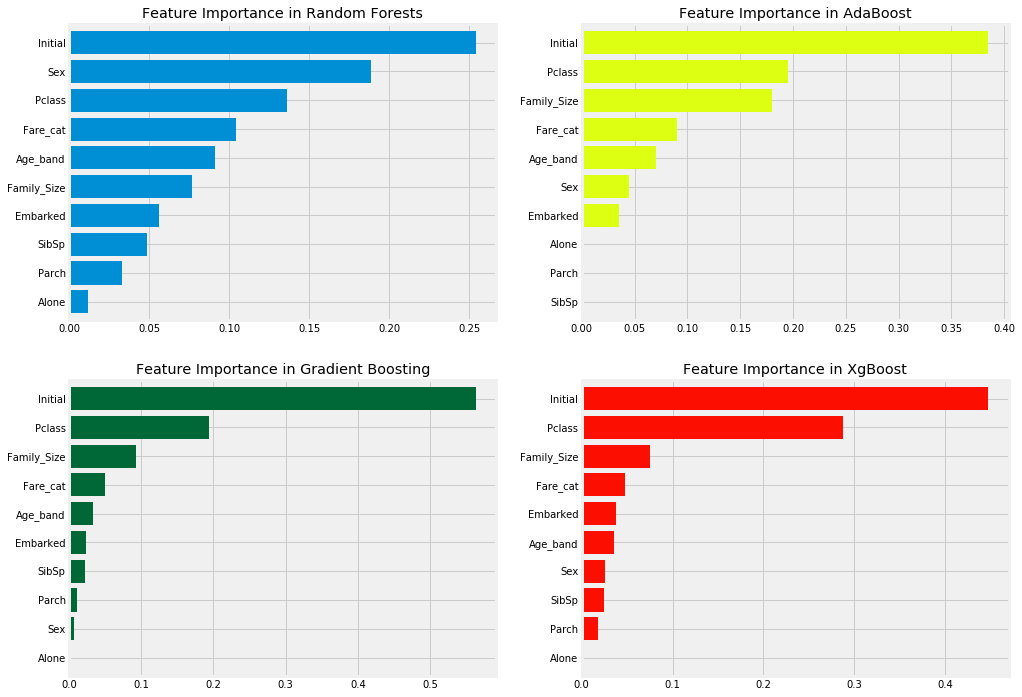

In [96]:
#feature importance
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')
model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')
model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')
model=xgb.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

In [97]:
#handle the missig value for Age
#find the Salutations and repace the NaN with the mean of age for that group
test_df['Initial']=0
for i in test_df:
    test_df['Initial']=test_df.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
test_df['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

pd.crosstab(test_df.Initial,test_df.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Dona,Master,Miss,Mr,Mrs,Other
Sex,,,,,,
female,1,0,79,0,72,0
male,0,21,0,241,0,4


In [98]:
test_df.groupby('Initial')['Age'].mean() 

Initial
Dona      39.000000
Master     7.406471
Miss      21.774844
Mr        32.114130
Mrs       38.903226
Other     42.750000
Name: Age, dtype: float64

In [99]:
#process the test data set for prediction

#correct the miss-spelling and replace
test_df['Initial'].replace(['Dona','Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Mrs','Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

test_df.groupby('Initial')['Age'].mean() 
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Mr'),'Age']=33
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Mrs'),'Age']=39
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Master'),'Age']=8
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Miss'),'Age']=22
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Other'),'Age']=43


#handle the missing value of Embarked
#replace with S since it's the port where most passengers boarded.
test_df['Embarked'].fillna('S',inplace=True)
test_df.Embarked.isnull().any()

False

In [100]:
#handle the missing value of Embarked
#replace with S since it's the port where most passengers boarded.
test_df['Embarked'].fillna('S',inplace=True)
test_df.Embarked.isnull().any()
#handle the missing value of Embarked
#replace with S since it's the port where most passengers boarded.
test_df['Embarked'].fillna('S',inplace=True)
test_df.Embarked.isnull().any()

False

In [101]:
#feature engineering-Convert Age to categorical variabled 
#(Max is 80,set bin number 5, width 16)
test_df['Age_band']=0
test_df.loc[test_df['Age']<=16,'Age_band']=0
test_df.loc[(test_df['Age']>16)&(test_df['Age']<=32),'Age_band']=1
test_df.loc[(test_df['Age']>32)&(test_df['Age']<=48),'Age_band']=2
test_df.loc[(test_df['Age']>48)&(test_df['Age']<=64),'Age_band']=3
test_df.loc[test_df['Age']>64,'Age_band']=4
test_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,2


In [102]:
#feature engineering - create new variables Family_Size (sum of Parch and SibSp) 
#and Alone (= 1 if Family_size ==0 otherwise 0)
test_df['Family_Size']=0
test_df['Family_Size']=test_df['Parch']+test_df['SibSp']#family size
test_df['Alone']=0
test_df.loc[test_df.Family_Size==0,'Alone']=1#Alone



In [103]:
#feature engineering - convert Fare to categorical feature
#first split the values to be equally space to several bins
#using the bound value to convert to categorical value
test_df['Fare_Range']=pd.qcut(test_df['Fare'],4)

test_df['Fare_cat']=0
test_df.loc[test_df['Fare']<=7.91,'Fare_cat']=0
test_df.loc[(test_df['Fare']>7.91)&(test_df['Fare']<=14.454),'Fare_cat']=1
test_df.loc[(test_df['Fare']>14.454)&(test_df['Fare']<=31),'Fare_cat']=2
test_df.loc[(test_df['Fare']>31)&(test_df['Fare']<=514),'Fare_cat']=3

In [104]:
#feature engineering - convert string values to numeric
test_df['Sex'].replace(['male','female'],[0,1],inplace=True)
test_df['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
test_df['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

In [105]:
test_df.groupby(['Sex', 'Initial'])['Initial'].count()

Sex  Initial
0    0          241
     3           21
     4            4
1    1           73
     2           79
Name: Initial, dtype: int64

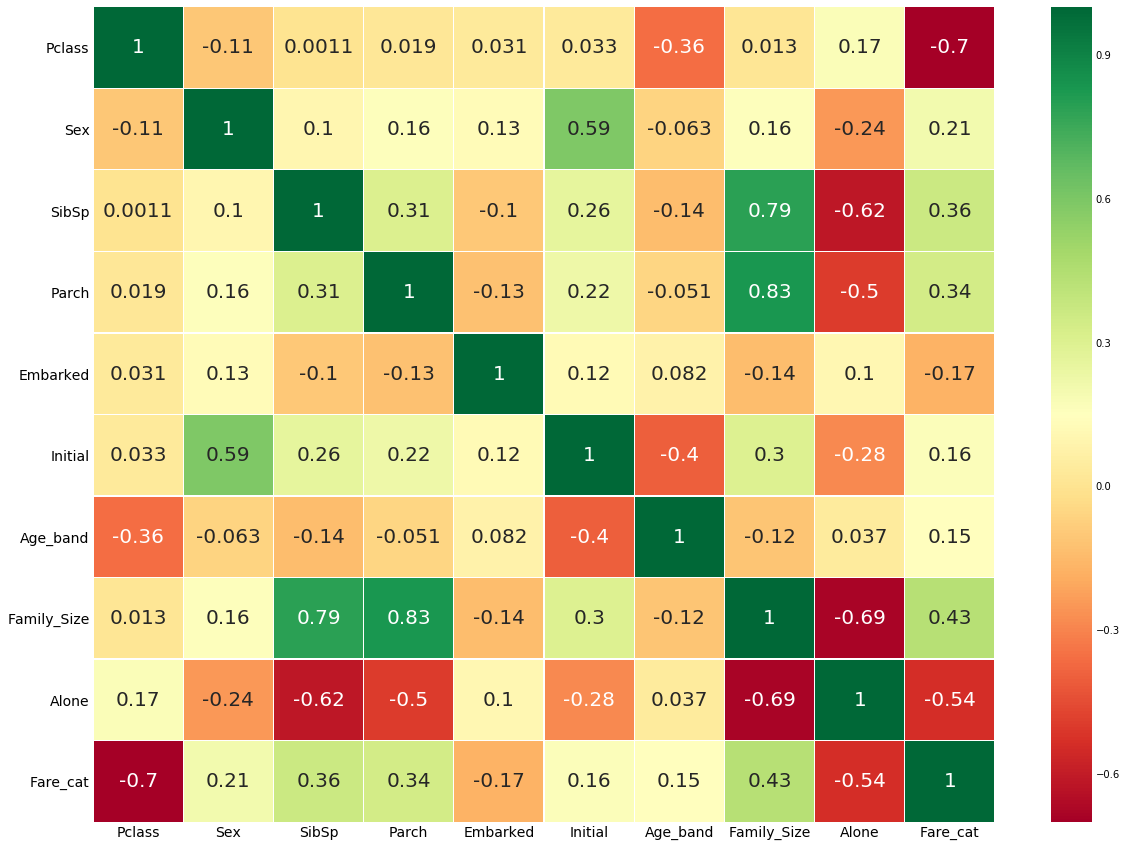

In [106]:
#feature engineering -drop unused features
test_df.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(test_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [107]:
test_df.head()

,Pclass,Sex,SibSp,Parch,Embarked,Initial,Age_band,Family_Size,Alone,Fare_cat
0,3,0,0,0,2,0,2,0,1,0
1,3,1,1,0,0,1,2,1,0,0
2,2,0,0,0,2,0,3,0,1,1
3,3,0,0,0,0,0,1,0,1,1
4,3,1,1,1,0,1,1,2,0,1


In [108]:
train_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Initial,Age_band,Family_Size,Alone,Fare_cat
0,0,3,0,1,0,0,0,1,1,0,0
1,1,1,1,1,0,1,1,2,1,0,3
2,1,3,1,0,0,0,2,1,0,1,1
3,1,1,1,1,0,0,1,2,1,0,3
4,0,3,0,0,0,0,0,2,0,1,1


In [109]:
#predict using the best model

xgb4 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)

prediction_test_xgb=xgb4.predict(test_df)

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.860783       0.006717       0.849856      0.025319
1         0.872630       0.005356       0.859846      0.024295
2         0.875220       0.006109       0.866449      0.022104
3         0.876360       0.004977       0.867506      0.023558
4         0.878499       0.005321       0.866685      0.023656
5         0.881269       0.006953       0.869874      0.023074
6         0.884184       0.005057       0.871653      0.025158
7         0.887971       0.002468       0.874980      0.023586
8         0.889559       0.001667       0.875895      0.022849
9         0.891163       0.003258       0.878364      0.019828
10        0.892136       0.003331       0.878994      0.017389
11        0.892786       0.003296       0.879514      0.017061
12        0.893230       0.003020       0.879417      0.019121
13        0.894432       0.002899       0.880065      0.017814
14        0.894559       0.003058       0.880053      0

In [112]:
print(prediction_test_xgb)

[0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 1 0 1 0 0 1]


In [113]:
print(type(prediction_test))
np.savetxt("../data/prediction_test.csv", prediction_test, delimiter = ",")

NameError: name 'prediction_test' is not defined

In [ ]:
#use the best GBM model to predict
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Survived'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Survived'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Survived'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Survived'], dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,max_depth=3,min_samples_split=8, min_samples_leaf=3, subsample=0.8, random_state=10,max_features=3)
modelfit(gbm_tuned_1, train, predictors)
prediction_test_gbm=gbm_tuned_1.predict(test_df)

In [ ]:
np.savetxt("../data/prediction_gbm.csv", prediction_test_gbm, delimiter = ",")

In [ ]:
#Radial Support Vector Machines(rbf-SVM)
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction_svm=model.predict(test_df)


In [ ]:
np.savetxt("../data/prediction_svm.csv", prediction_svm, delimiter = ",")

In [ ]:
submission = pd.read_csv('../data/gender_submission.csv')
submission['Survived'] = prediction_test_gbm
submission.to_csv('../submission/submission_gbm.csv', index=False)

In [ ]:
submission = pd.read_csv('../data/gender_submission.csv')
submission['Survived'] = prediction_test_xgb
submission.to_csv('../submission/submission_xgb.csv', index=False)